[日本語Wikipedia](https://ja.wikipedia.org/)の「[人工知能](https://ja.wikipedia.org/wiki/%E4%BA%BA%E5%B7%A5%E7%9F%A5%E8%83%BD)」に関する記事からテキスト部分を抜き出したファイルが[ai.ja.zip](https://nlp100.github.io/data/ai.ja.zip)に収録されている． この文章を[CaboCha](https://taku910.github.io/cabocha/)や[KNP](http://nlp.ist.i.kyoto-u.ac.jp/index.php?KNP)等のツールを利用して係り受け解析を行い，その結果をai.ja.txt.parsedというファイルに保存せよ．このファイルを読み込み，以下の問に対応するプログラムを実装せよ．

In [1]:
import CaboCha

cp = CaboCha.Parser()
with open('ai.ja.txt', encoding='utf-8') as f:
    rows = f.read().split('\n')

with open('ai.ja.txt.parsed', 'w', encoding='utf-8') as f:
    for row in rows:
        if row and row != '人工知能':
            for sentence in row.strip().split('。'):
                if sentence:
                    tree = cp.parse(sentence + '。')
                    f.write(tree.toString(CaboCha.FORMAT_LATTICE))

## 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [2]:
from dataclasses import dataclass
from typing import List


@dataclass
class Morph:
    surface: str
    base: str
    pos: str
    pos1: str


with open('ai.ja.txt.parsed', encoding='utf-8') as f:
    morphs: List[Morph] = []
    morphs_list: List[List[Morph]] = []
    for line in iter(f.readline, ''):
        if (line := line.rstrip()):
            if line == 'EOS':
                morphs_list.append(morphs)
                morphs = []
            elif not line.startswith('*'):
                # 表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音
                surface, feature = line.split('\t')
                # len(feature)==7のものも存在する模様
                pos, pos1, _, _, _, _, base, *_ = feature.split(',')
                morphs.append(
                    Morph(surface=surface, base=base, pos=pos, pos1=pos1))

print(f'num of sentences: {len(morphs_list)}')
morphs_list[-1]

num of sentences: 213


[Morph(surface='おかげ', base='おかげ', pos='名詞', pos1='一般'),
 Morph(surface='で', base='で', pos='助詞', pos1='格助詞'),
 Morph(surface='、', base='、', pos='記号', pos1='読点'),
 Morph(surface='意見', base='意見', pos='名詞', pos1='サ変接続'),
 Morph(surface='の', base='の', pos='助詞', pos1='連体化'),
 Morph(surface='違い', base='違い', pos='名詞', pos1='ナイ形容詞語幹'),
 Morph(surface='は', base='は', pos='助詞', pos1='係助詞'),
 Morph(surface='明らか', base='明らか', pos='名詞', pos1='形容動詞語幹'),
 Morph(surface='に', base='に', pos='助詞', pos1='格助詞'),
 Morph(surface='なっ', base='なる', pos='動詞', pos1='自立'),
 Morph(surface='た', base='た', pos='助動詞', pos1='*'),
 Morph(surface='と', base='と', pos='助詞', pos1='格助詞'),
 Morph(surface='は', base='は', pos='助詞', pos1='係助詞'),
 Morph(surface='思い', base='思う', pos='動詞', pos1='自立'),
 Morph(surface='ます', base='ます', pos='助動詞', pos1='*'),
 Morph(surface='が', base='が', pos='助詞', pos1='接続助詞'),
 Morph(surface='、', base='、', pos='記号', pos1='読点'),
 Morph(surface='果たして', base='果たして', pos='副詞', pos1='一般'),
 Morph(surface='何', b

## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [3]:
from collections import defaultdict
from dataclasses import dataclass
from typing import DefaultDict, List


@dataclass
class Chunk:
    morphs: List[Morph]
    dst: int
    srcs: List[int]


with open('ai.ja.txt.parsed', encoding='utf-8') as f:
    chunks_list: List[List[Chunk]] = []
    morphs_list: List[List[Morph]] = []
    dsts: List[int] = []
    chunk_num2srcs: DefaultDict[int, List[int]] = defaultdict(list)
    for line in iter(f.readline, ''):
        if (line := line.rstrip()):
            if line.startswith('*'):
                # * 文節番号 かかり先の文節番号 主辞/機能語の位置 係り関係のスコア
                _, chunk_num, dst, *_ = line.split(' ')
                chunk_num, dst = int(chunk_num), int(dst[:-1])
                morphs_list.append([])
                dsts.append(dst)
                chunk_num2srcs[dst].append(chunk_num)
            elif line == 'EOS':
                chunks_list.append([
                    Chunk(morphs=morphs,
                          dst=dst,
                          srcs=chunk_num2srcs.get(i, []))
                    for i, (morphs, dst) in enumerate(zip(morphs_list, dsts))
                ])
                morphs_list, dsts, chunk_num2srcs = [], [], defaultdict(list)
            else:
                # 表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音
                surface, feature = line.split('\t')
                # len(feature)==7のものも存在する模様
                pos, pos1, _, _, _, _, base, *_ = feature.split(',')
                morphs_list[-1].append(
                    Morph(surface=surface, base=base, pos=pos, pos1=pos1))

for i, chunk in enumerate(chunks_list[-1]):
    print(f'Chunk {i}')
    print(f'  dst: {chunk.dst}')
    print(f'  srcs: {chunk.srcs}')
    for morph in chunk.morphs:
        print(f'  morph: {morph}')

Chunk 0
  dst: 3
  srcs: []
  morph: Morph(surface='おかげ', base='おかげ', pos='名詞', pos1='一般')
  morph: Morph(surface='で', base='で', pos='助詞', pos1='格助詞')
  morph: Morph(surface='、', base='、', pos='記号', pos1='読点')
Chunk 1
  dst: 2
  srcs: []
  morph: Morph(surface='意見', base='意見', pos='名詞', pos1='サ変接続')
  morph: Morph(surface='の', base='の', pos='助詞', pos1='連体化')
Chunk 2
  dst: 3
  srcs: [1]
  morph: Morph(surface='違い', base='違い', pos='名詞', pos1='ナイ形容詞語幹')
  morph: Morph(surface='は', base='は', pos='助詞', pos1='係助詞')
Chunk 3
  dst: 4
  srcs: [0, 2]
  morph: Morph(surface='明らか', base='明らか', pos='名詞', pos1='形容動詞語幹')
  morph: Morph(surface='に', base='に', pos='助詞', pos1='格助詞')
  morph: Morph(surface='なっ', base='なる', pos='動詞', pos1='自立')
  morph: Morph(surface='た', base='た', pos='助動詞', pos1='*')
  morph: Morph(surface='と', base='と', pos='助詞', pos1='格助詞')
  morph: Morph(surface='は', base='は', pos='助詞', pos1='係助詞')
Chunk 4
  dst: 8
  srcs: [3]
  morph: Morph(surface='思い', base='思う', pos='動詞', pos1='

## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [4]:
def convert_chunk2surface(chunk: Chunk) -> str:
    return ''.join(
        [morph.surface for morph in chunk.morphs if morph.pos != '記号'])


results = []
for chunks in chunks_list:
    result = []
    for chunk in chunks:
        self = convert_chunk2surface(chunk)
        src = '\t'.join(
            [convert_chunk2surface(chunks[src_idx]) for src_idx in chunk.srcs])
        dst = convert_chunk2surface(
            chunks[chunk.dst]) if chunk.dst != -1 else ''
        result.append((self, src, dst))
    results.append(result)

for i, (self, src, dst) in enumerate(results[-1]):
    print(f'Chunk {i}')
    print(f'  係り元の文節: {src}')
    print(f'  　当該の文節: {self}')
    print(f'  係り先の文節: {dst}')

Chunk 0
  係り元の文節: 
  　当該の文節: おかげで
  係り先の文節: 明らかになったとは
Chunk 1
  係り元の文節: 
  　当該の文節: 意見の
  係り先の文節: 違いは
Chunk 2
  係り元の文節: 意見の
  　当該の文節: 違いは
  係り先の文節: 明らかになったとは
Chunk 3
  係り元の文節: おかげで	違いは
  　当該の文節: 明らかになったとは
  係り先の文節: 思いますが
Chunk 4
  係り元の文節: 明らかになったとは
  　当該の文節: 思いますが
  係り先の文節: つくのでしょうかと
Chunk 5
  係り元の文節: 
  　当該の文節: 果たして
  係り先の文節: つくのでしょうかと
Chunk 6
  係り元の文節: 
  　当該の文節: 何か
  係り先の文節: つくのでしょうかと
Chunk 7
  係り元の文節: 
  　当該の文節: 決着が
  係り先の文節: つくのでしょうかと
Chunk 8
  係り元の文節: 思いますが	果たして	何か	決着が
  　当該の文節: つくのでしょうかと
  係り先の文節: 発言し
Chunk 9
  係り元の文節: つくのでしょうかと
  　当該の文節: 発言し
  係り先の文節: 答えている
Chunk 10
  係り元の文節: 
  　当該の文節: 伊勢田は
  係り先の文節: 答えている
Chunk 11
  係り元の文節: 
  　当該の文節: 決着は
  係り先の文節: つかないでしょうねと
Chunk 12
  係り元の文節: 決着は
  　当該の文節: つかないでしょうねと
  係り先の文節: 答えている
Chunk 13
  係り元の文節: 発言し	伊勢田は	つかないでしょうねと
  　当該の文節: 答えている
  係り先の文節: 


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [5]:
def convert_chunk2surface(chunk: Chunk) -> str:
    return ''.join(
        [morph.surface for morph in chunk.morphs if morph.pos != '記号'])


results = []
for chunks in chunks_list:
    for chunk in chunks:
        has_noun = any([morph.pos == '名詞' for morph in chunk.morphs])
        has_verb = any([
            morph.pos == '動詞' for morph in chunks[chunk.dst].morphs
        ]) if chunk.dst != -1 else False
        if has_noun and has_verb:
            self = convert_chunk2surface(chunk)
            dst = convert_chunk2surface(chunks[chunk.dst])
            results.append(f'{self} -> {dst}')

for r in results[-13:]:
    print(r)

須藤は -> 行ってきました
これまで -> 行ってきました
長時間 -> 行ってきました
議論を -> 行ってきました
おかげで -> 明らかになったとは
違いは -> 明らかになったとは
明らかになったとは -> 思いますが
何か -> つくのでしょうかと
決着が -> つくのでしょうかと
つくのでしょうかと -> 発言し
発言し -> 答えている
伊勢田は -> 答えている
決着は -> つかないでしょうねと


## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，[Graphviz](http://www.graphviz.org/)等を用いるとよい．

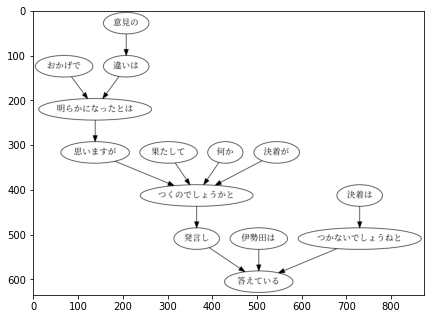

In [6]:
import pydot
from matplotlib import pyplot as plt
%matplotlib inline


def convert_chunk2surface(chunk: Chunk) -> str:
    return ''.join(
        [morph.surface for morph in chunk.morphs if morph.pos != '記号'])


G = pydot.Dot()

for chunk in (chunks := chunks_list[-1]):
    if chunk.dst != -1:
        self = convert_chunk2surface(chunk)
        dst = convert_chunk2surface(chunks[chunk.dst])
        G.add_edge(pydot.Edge(self, dst))

G.write_png('dependency.png')

img = plt.imread('dependency.png')
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．
- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．
```
作り出す	で は を
```

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．
- コーパス中で頻出する述語と格パターンの組み合わせ
- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [7]:
case_patterns = []
for chunks in chunks_list:
    for chunk in chunks:
        if (verbs :=
            [morph.base for morph in chunk.morphs if morph.pos == '動詞']):
            verb = verbs[0]
            particles = []
            for src in chunk.srcs:
                for morph in chunks[src].morphs[::-1]:
                    if morph.pos != '記号':
                        if morph.pos == '助詞':
                            particles.append(morph.base)
                        break
            if particles:
                case_patterns.append(verb + '\t' + ' '.join(particles))

with open('case_patterns.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(case_patterns))

for cp in case_patterns[-10:]:
    print(cp)

する	は と
しれる	は
述べる	は と
行う	で は まで を
なる	で は
思う	は
つく	が か が
する	と
つく	は
答える	は と


In [8]:
!cat case_patterns.txt | sort | uniq -c | sort -r | head -n 11

     53 する	を
     19 する	と
     17 する	が
     15 する	に
     11 よる	に
     11 する	は を
      9 行う	を
      9 する	は と
      7 する	を に
      6 基づく	に
      6 呼ぶ	と


In [9]:
!grep '行う' case_patterns.txt | sort | uniq -c | sort -r | head -n 5

      9 行う	を
      1 行う	を に を
      1 行う	まで を に
      1 行う	は を をめぐって
      1 行う	は を


In [10]:
!grep 'なる' case_patterns.txt | sort | uniq -c | sort -r | head -n 5

      3 なる	は に
      3 なる	が と
      2 なる	は も
      2 なる	に
      2 なる	と


In [11]:
!grep '与える' case_patterns.txt | sort | uniq -c | sort -r

      2 与える	が に
      1 与える	は に を


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．
- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．
```
作り出す	で は を	会議で ジョンマッカーシーは 用語を
```

In [12]:
def convert_chunk2surface(chunk: Chunk) -> str:
    return ''.join(
        [morph.surface for morph in chunk.morphs if morph.pos != '記号'])


case_patterns = []
for chunks in chunks_list:
    for chunk in chunks:
        if (verbs :=
            [morph.base for morph in chunk.morphs if morph.pos == '動詞']):
            verb = verbs[0]
            particles = []
            frames = []
            for src in chunk.srcs:
                for morph in chunks[src].morphs[::-1]:
                    if morph.pos != '記号':
                        if morph.pos == '助詞':
                            particles.append(morph.base)
                            frames.append(convert_chunk2surface(chunks[src]))
                        break
            if particles:
                case_patterns.append(verb + '\t' + ' '.join(particles) + '\t' +
                                     ' '.join(frames))

for cp in case_patterns[-10:]:
    print(cp)

する	は と	須藤は 確かでしょうと
しれる	は	違いというのは
述べる	は と	伊勢田は 大きいのかもしれませんと
行う	で は まで を	対談で 須藤は これまで 議論を
なる	で は	おかげで 違いは
思う	は	明らかになったとは
つく	が か が	思いますが 何か 決着が
する	と	つくのでしょうかと
つく	は	決着は
答える	は と	伊勢田は つかないでしょうねと


## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．
- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「また、自らの経験を元に学習を行う強化学習という手法もある。」という文から，以下の出力が得られるはずである．
```
学習を行う	に を	元に 経験を
```

In [13]:
def convert_chunk2surface(chunk: Chunk) -> str:
    return ''.join(
        [morph.surface for morph in chunk.morphs if morph.pos != '記号'])


case_patterns = []
for chunks in chunks_list:
    for chunk in chunks:
        if (verbs :=
            [morph.base for morph in chunk.morphs if morph.pos == '動詞']):
            verb = verbs[0]
            for src in chunk.srcs:
                if len(
                    (morphs := chunks[src].morphs)
                ) == 2 and morphs[0].pos1 == 'サ変接続' and morphs[1].base == 'を':
                    verb = morphs[0].base + morphs[1].base + verb
                    particles = []
                    frames = []
                    for sub_src in chunks[src].srcs:
                        for morph in chunks[sub_src].morphs[::-1]:
                            if morph.pos != '記号':
                                if morph.pos == '助詞':
                                    particles.append(morph.base)
                                    frames.append(
                                        convert_chunk2surface(chunks[sub_src]))
                                break
                    if particles:
                        case_patterns.append(verb + '\t' +
                                             ' '.join(particles) + '\t' +
                                             ' '.join(frames))

for cp in case_patterns[-10:]:
    print(cp)

展開を変える	の	部隊の
判断を介す	の	人間の
禁止を求める	の	自動操縦型武器の
運用をめぐる	の	AI兵器の
記録をする	の	米軍の
試験を行う	の	世界最大規模の
共同研究をする	と の	教育機関と AIの
解散をする	の	委員会の
実現をする	の	Godheadの
話をする	の	異界の


## 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．
- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した
```

KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
ジョンマッカーシーは -> 作り出した
ＡＩに -> 関する -> 会議で -> 作り出した
会議で -> 作り出した
人工知能と -> いう -> 用語を -> 作り出した
用語を -> 作り出した
```

In [14]:
def convert_chunk2surface(chunk: Chunk) -> str:
    return ''.join(
        [morph.surface for morph in chunk.morphs if morph.pos != '記号'])


results = []
for chunks in chunks_list:
    for chunk in chunks:
        if any(morph.pos == '名詞' for morph in chunk.morphs):
            paths = [convert_chunk2surface(chunk)]
            while True:
                chunk = chunks[chunk.dst]
                paths.append(convert_chunk2surface(chunk))
                if chunk.dst == -1:
                    break
            results.append(' -> '.join(paths))

for r in results[-10:]:
    print(r)

おかげで -> 明らかになったとは -> 思いますが -> つくのでしょうかと -> 発言し -> 答えている
意見の -> 違いは -> 明らかになったとは -> 思いますが -> つくのでしょうかと -> 発言し -> 答えている
違いは -> 明らかになったとは -> 思いますが -> つくのでしょうかと -> 発言し -> 答えている
明らかになったとは -> 思いますが -> つくのでしょうかと -> 発言し -> 答えている
何か -> つくのでしょうかと -> 発言し -> 答えている
決着が -> つくのでしょうかと -> 発言し -> 答えている
つくのでしょうかと -> 発言し -> 答えている
発言し -> 答えている
伊勢田は -> 答えている
決着は -> つかないでしょうねと -> 答えている


## 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がiとj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．
- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を” -> “で連結して表現する
- 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．
- 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
- 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を” | “で連結して表示

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
```

KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
Xは | Yに -> 関する -> 会議で | 作り出した。
Xは | Yで | 作り出した。
Xは | Yと -> いう -> 用語を | 作り出した。
Xは | Yを | 作り出した。
Xに -> 関する -> Yで
Xに -> 関する -> 会議で | Yと -> いう -> 用語を | 作り出した。
Xに -> 関する -> 会議で | Yを | 作り出した。
Xで | Yと -> いう -> 用語を | 作り出した。
Xで | Yを | 作り出した。
Xと -> いう -> Yを
```